In [ ]:
import numpy as np
from scipy.stats import poisson
from scipy.stats import norm
import matplotlib.pyplot as plt
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
%matplotlib inline

# Gaussian EM Implementation

In [ ]:
class norm_clusters():
    def __init__(self, data, num_steps, tol=1e-2):
        '''
        data: numpy array of dimensions (num_samples, num_features)
        '''
        self.data = data
        self.num_data = len(self.data)
        self.num_steps = num_steps
        self.tol = tol

    def prob_gaussian(self, data_point, cluster_mean, std):
        '''Returns the probability of data_point coming from a Gaussian distribution with means=cluster_mean'''
        prob = 1
        for k, mu, std in zip(data_point, cluster_mean, std):
            # print(cluster_mean)
            prob*=norm.pdf(k, mu, std)
        # print(prob)
        return prob

    def likelihoods(self, cluster_mean_list, mixing_coefficients, std):
        likelihoods = [[pi*self.prob_gaussian(data_point, cluster_mean, std) for cluster_mean, pi, std in zip(cluster_mean_list, mixing_coefficients, std)] for data_point in self.data]
        # print(mixing_coefficients)
        # print(cluster_mean_list)
        return likelihoods

    def log_likelihood(self, cluster_mean_list, mixing_coefficients, std):
        likelihoods = self.likelihoods(cluster_mean_list, mixing_coefficients, std)
        # print(likelihoods)
        log_likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))
        return log_likelihood

    def fit(self, num_clusters):
        self.log_likelihood_list = []

        #Initialize means and mixing coefficients
        rand_idxs = np.random.permutation(len(self.data))
        rand_idxs_partitioned = [rand_idxs[int(i*self.num_data/num_clusters):int((i+1)*self.num_data/num_clusters)] for i in range(num_clusters)]
        self.fit_means = np.array([np.mean(self.data[idxs], axis=0) for idxs in rand_idxs_partitioned])
        self.fit_std = np.array([np.std(self.data[idxs], axis=0) for idxs in rand_idxs_partitioned])
        self.mixing_coeff = np.ones(num_clusters)/num_clusters
        # print(self.fit_means)
        # print(self.mixing_coeff)

        #Calculate initial value of log-likelihood
        self.log_likelihood_list.append(self.log_likelihood(self.fit_means, self.mixing_coeff, self.fit_std))
        # print(self.log_likelihood_list)

        #Loop over E steps and M step
        for _ in range(self.num_steps):
            #E-step
            #Evaluate responsibilities
            self.responsibilities = self.likelihoods(self.fit_means, self.mixing_coeff, self.fit_std)
            self.responsibilities /= np.sum(self.responsibilities, axis=1)[:, np.newaxis]

            #M-step
            #Re-estimate parameters
            N_k = np.sum(self.responsibilities, axis=0)
            self.fit_means = np.matmul(self.responsibilities.T, self.data)/N_k[:, np.newaxis]
            self.fit_std = np.sqrt(np.sum(self.responsibilities[:, :, np.newaxis] * (self.data[:, np.newaxis, :] - self.fit_means)**2, axis=0) / N_k[:, np.newaxis])
            self.mixing_coeff = N_k/self.num_data

            #Evaluate log-likelihood
            self.log_likelihood_list.append(self.log_likelihood(self.fit_means, self.mixing_coeff, self.fit_std))

            if self.log_likelihood_list[-1] - self.log_likelihood_list[-2] < self.tol:
                break
        # print(self.log_likelihood_list)
        plt.plot(np.arange(len(self.log_likelihood_list)), self.log_likelihood_list)
        plt.xticks(np.arange(len(self.log_likelihood_list)))
        plt.xlabel('Steps')
        plt.ylabel('Log-likelihood')
        plt.show()

# Synthetic Data: Gaussian

In [ ]:
#create cluster means here shown for two clusters
gaussian_means = 20*np.random.random(size=(2, 100))
gaussian_std = 5*np.random.random(size=(2, 100))
#generate datapoints for each cluster and plot
gaussian_data = np.vstack([np.random.normal(mean, std, size=(500, 100)) for mean, std in zip(gaussian_means, gaussian_std)])

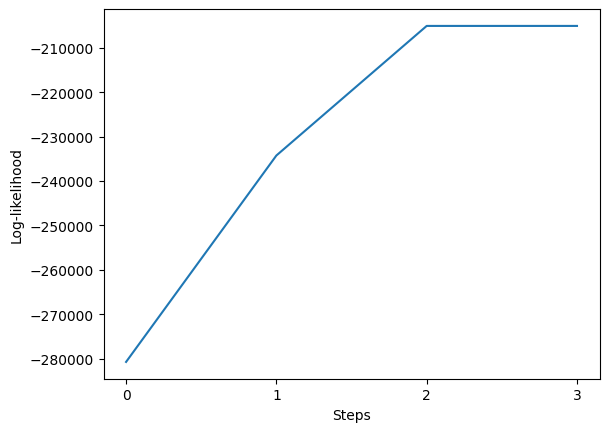

In [ ]:
#Fit poisson_clusters model with two clusters
num_clusters = 2
obj = norm_clusters(data=gaussian_data, num_steps=10)
obj.fit(num_clusters=num_clusters)

Get Predictions

In [ ]:
preds_normal = np.argmax(obj.responsibilities, axis = 1)

Predictions PCA

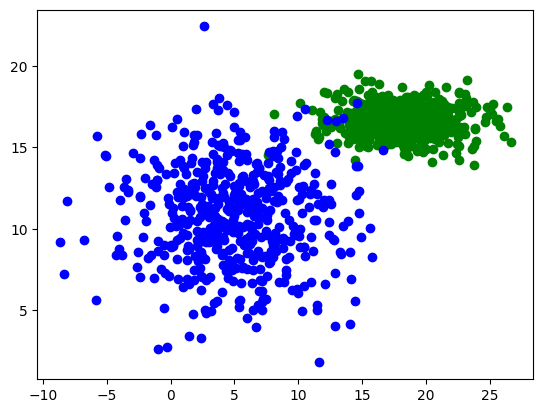

In [ ]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(poisson_data)
plt.scatter(gaussian_data[preds_normal == 0,1], gaussian_data[preds_normal == 0,0], color='green')
plt.scatter(gaussian_data[preds_normal == 1,1], gaussian_data[preds_normal == 1,0], color='blue')

Adjusted Rand Score

In [ ]:
adjusted_rand_score(np.hstack((np.zeros(500), np.ones(500))), preds_normal)

1.0

Ground Truth PCA

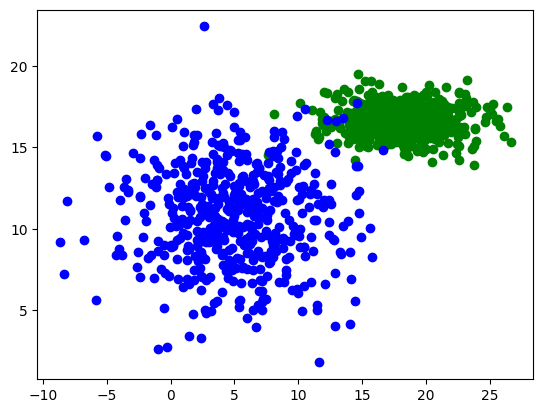

In [ ]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(poisson_data)
plt.scatter(gaussian_data[:500,1], gaussian_data[:500,0], color='green')
plt.scatter(gaussian_data[500:1000,1], gaussian_data[500:1000,0], color='blue')

# Real World Data: Only Gender

Loading and Pre-processing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_file_list = glob.glob('/content/drive/MyDrive/ML project/data_*.csv')
data_list = []
for file in data_file_list:
  if file == '/content/drive/MyDrive/ML project/data_cortex_oligo.csv':
    continue
  data = pd.read_csv(file, index_col = 0)
  data = np.array(data)

  # normalize.
  normalized_data = data/np.sum(data, axis = 1)[:,np.newaxis]

  # scale.
  scaler = StandardScaler()
  single_cell_data_scaled = scaler.fit_transform(normalized_data)

  data_list.append(single_cell_data_scaled)


meta_file_list = glob.glob('/content/drive/MyDrive/ML project/meta_*.csv')
labels_gender_list = []
file_names_list = []
labels_cell_names_list = []
for file in meta_file_list:
  # print(file)
  file_name = '.'
  file_names_list.append(file_name.join(file.rstrip('.csv').split('_')[1:]))
  meta_data = pd.read_csv(file, index_col = 0)
  labels_gender = meta_data['mouse.sex'].apply(lambda x: 0 if x == 'M' else 1)
  labels_gender = np.array(labels_gender)
  labels_gender_list.append(labels_gender)


Running the Model

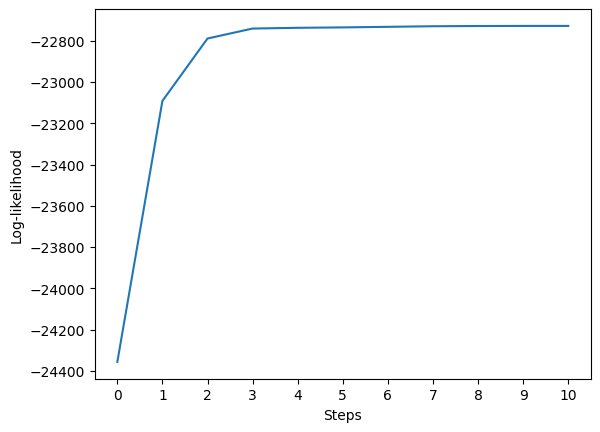

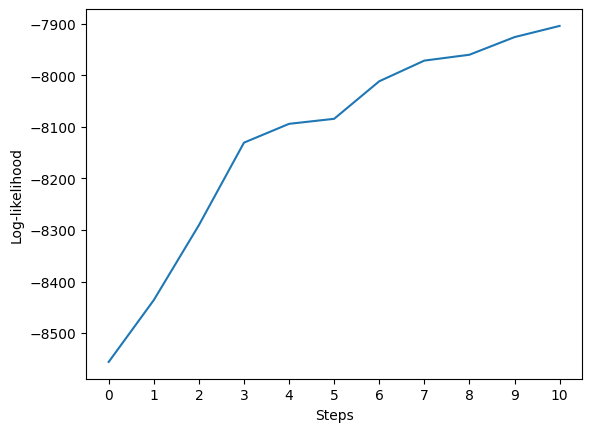

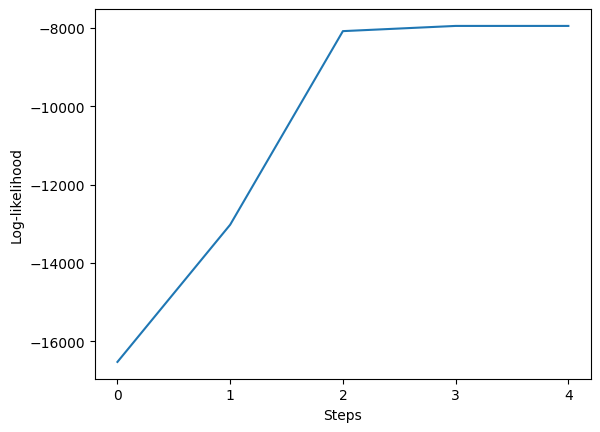

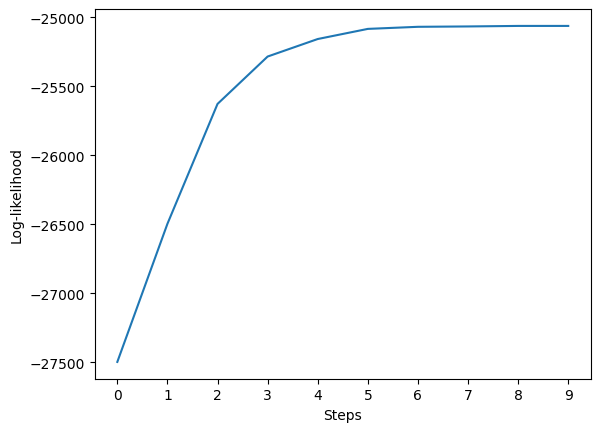

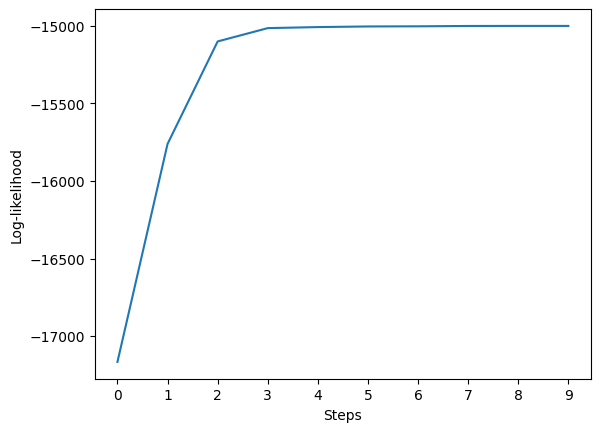

<ipython-input-3-569812ff899f>:29: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))


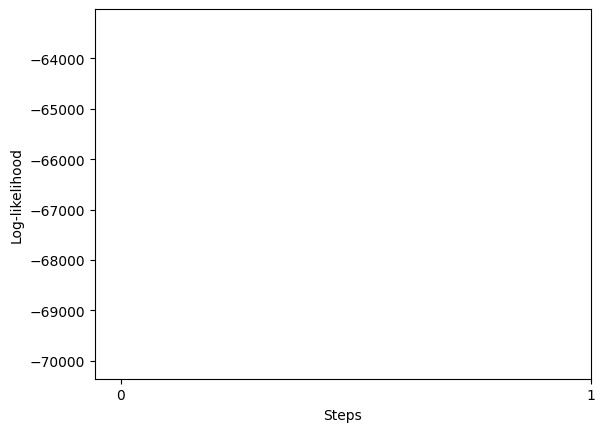

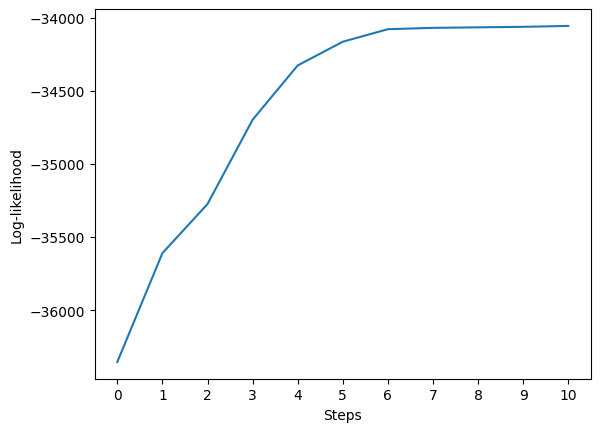

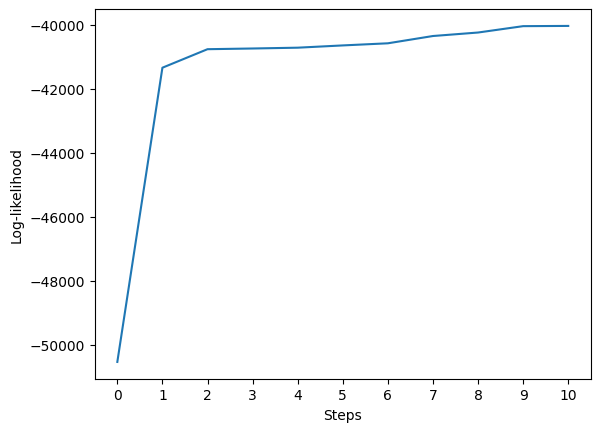

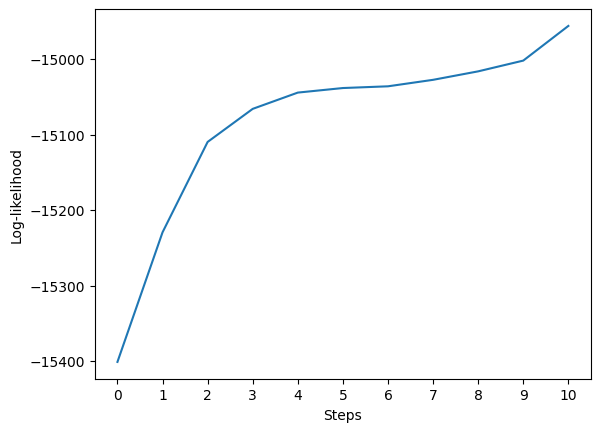

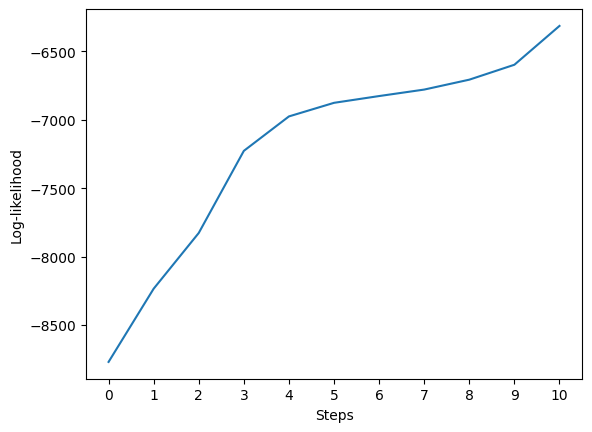

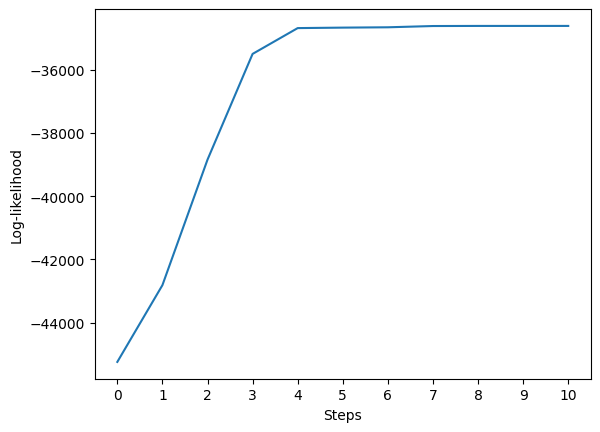

In [ ]:
num_clusters = 2

gender_scores_d_gender = {}
preds_list_gender = []
for data, gender_labels, file_name in zip(data_list, labels_gender_list, file_names_list):

  obj = norm_clusters(data=data, num_steps=10, tol = 1e-2)
  obj.fit(num_clusters=num_clusters)
  # print()
  # predict.
  preds = np.argmax(obj.responsibilities, axis = 1)
  preds_list_gender.append(preds)

  # evaluate.
  ## 1. gender.
  gender_scores_d_gender[file_name] = adjusted_rand_score(gender_labels, preds)

Adjusted Rand Scores

In [ ]:
gender_scores_d_gender

{'Cerebellum.endothelial cell': 0.09028703772546977,
 'Cerebellum.neuron': 0.017390386003203494,
 'Cerebellum.oligodendrocyte': -0.025549661057292568,
 'Cortex.astrocyte': 0.038405592747632125,
 'Cortex.endothelial cell': 0.5742473734660102,
 'Cortex.oligodendrocyte': -0.016861666805267548,
 'Hippocampus.endothelial cell': 0.02384053012565465,
 'Hippocampus.oligodendrocyte': 0.4617440162996337,
 'Striatum.endothelial cell': 0.08313169118287057,
 'Striatum.neuron': -0.06827548562529108,
 'Striatum.oligodendrocyte': 0.6333044137972333}

Predictions PCA

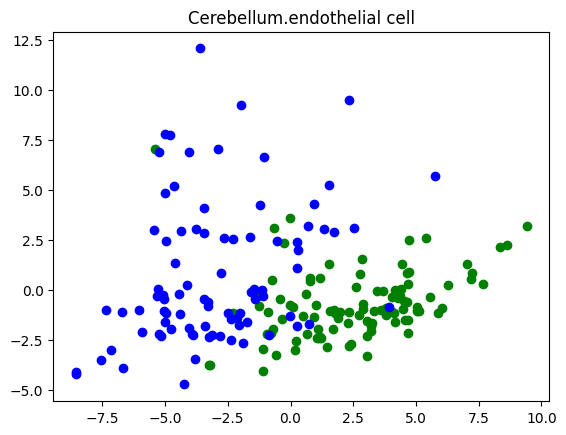

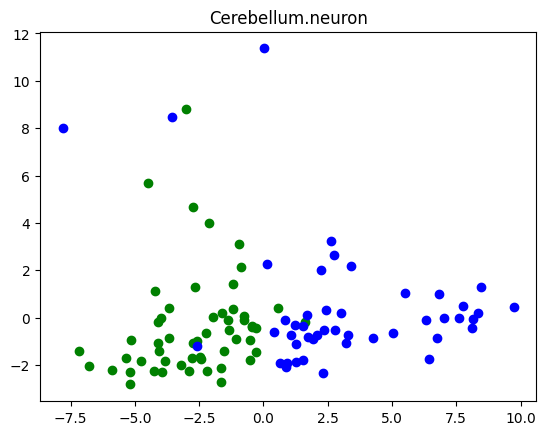

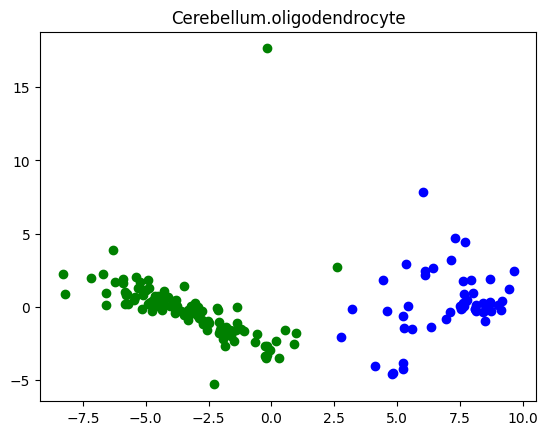

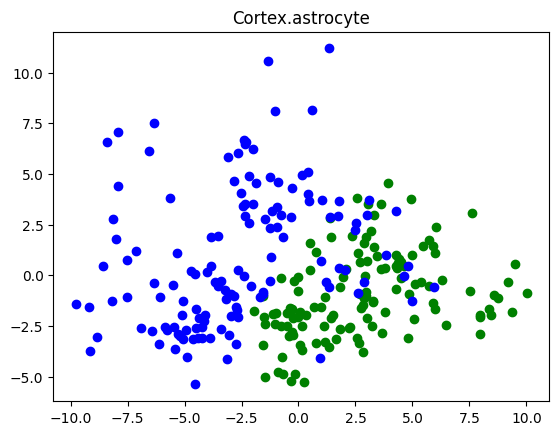

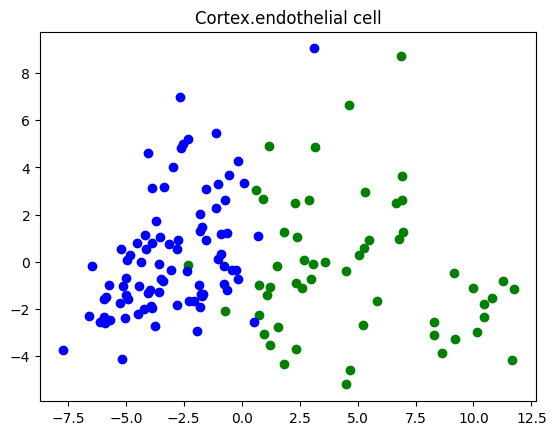

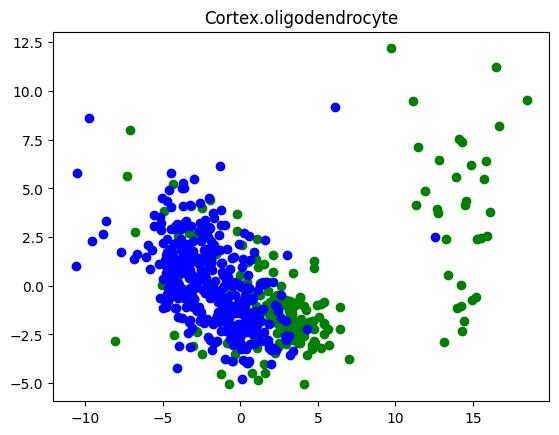

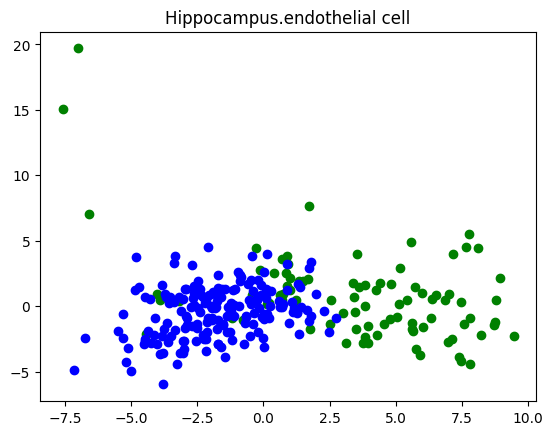

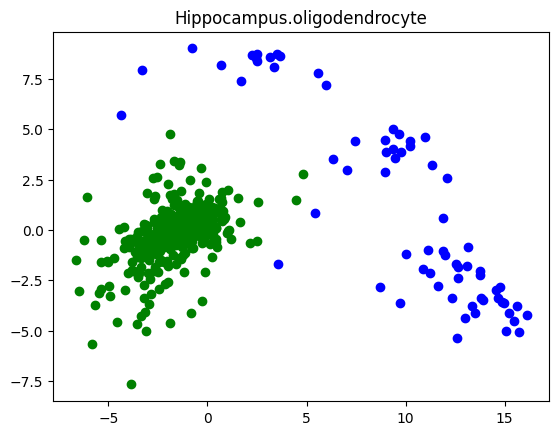

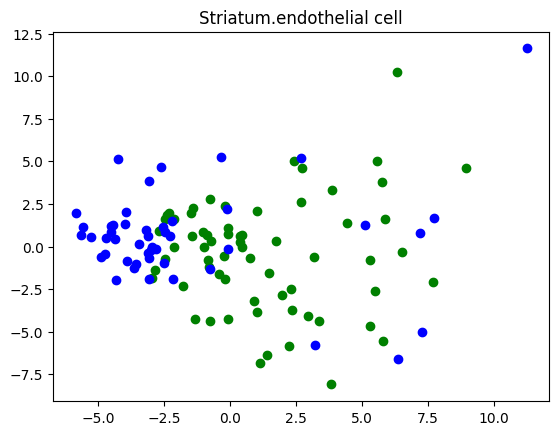

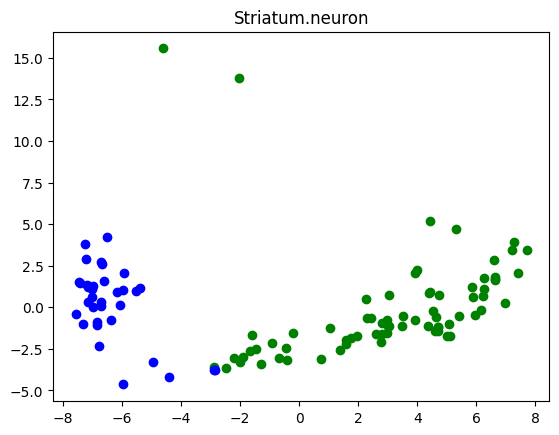

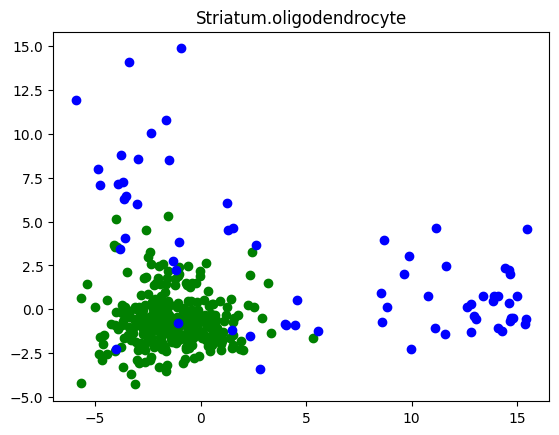

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

for data, gender_labels, file_names, pred in zip(data_list, labels_gender_list, file_names_list, preds_list_gender):

  pca = PCA(n_components=2)
  transformed_data = pca.fit_transform(data)

  # PCAs colored by gender.
  plt.scatter(transformed_data[pred==0, 0], transformed_data[pred==0, 1], color='green')
  plt.scatter(transformed_data[pred==1, 0], transformed_data[pred==1, 1], color='blue')
  plt.title(file_names)
  plt.show()

  # # PCAs colored by cell ontology.
  # plt.scatter(transformed_data[cell_labels==0, 0], transformed_data[cell_labels==0, 1], color='red')
  # plt.scatter(transformed_data[cell_labels==1, 0], transformed_data[cell_labels==1, 1], color='black')
  # plt.show()

Ground Truth PCA

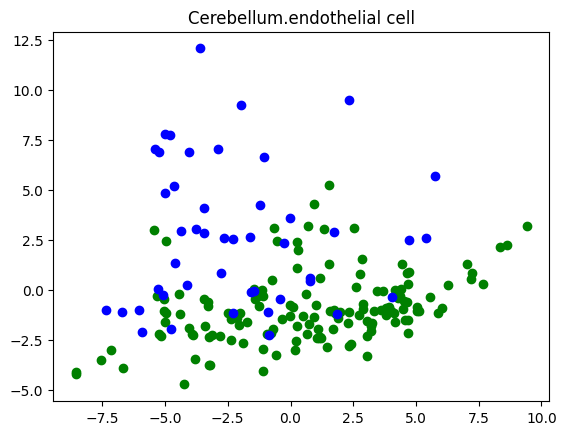

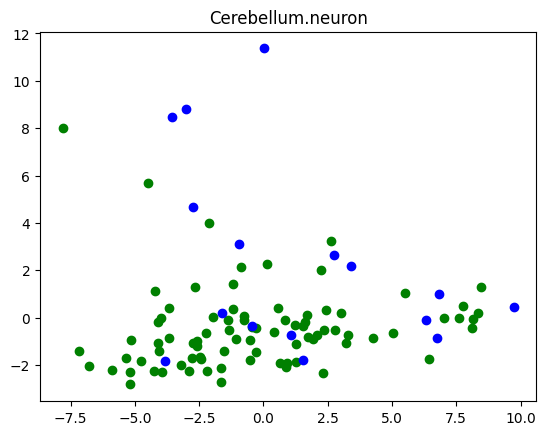

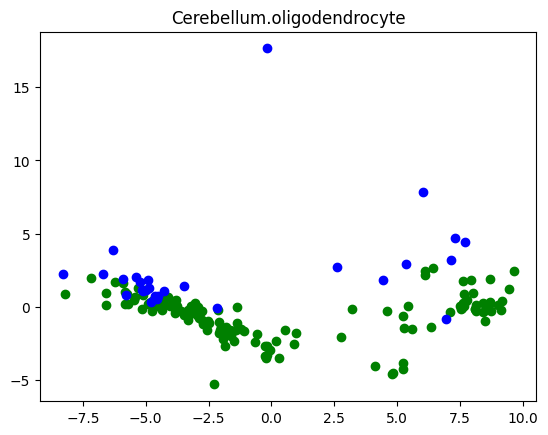

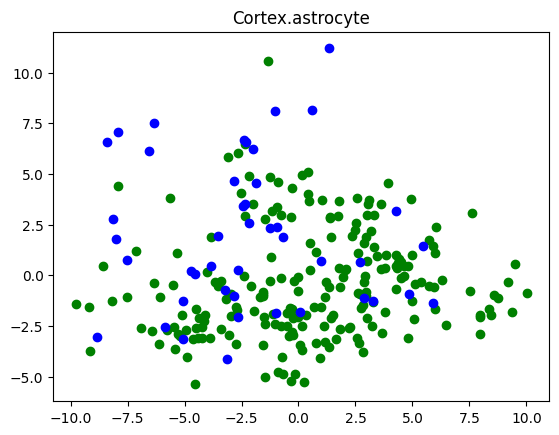

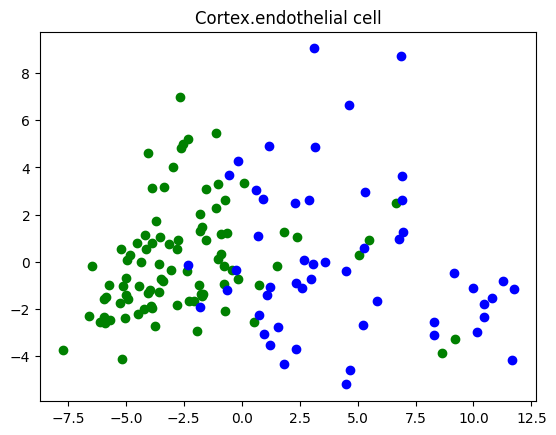

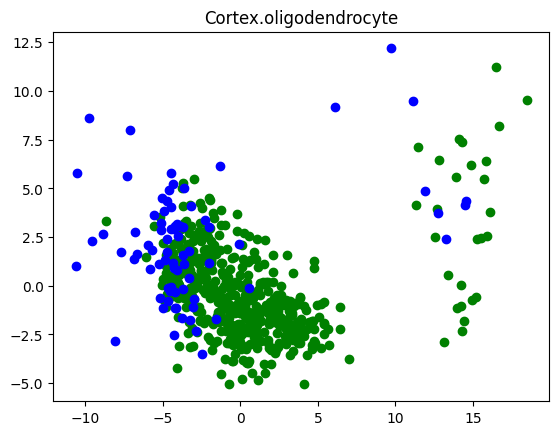

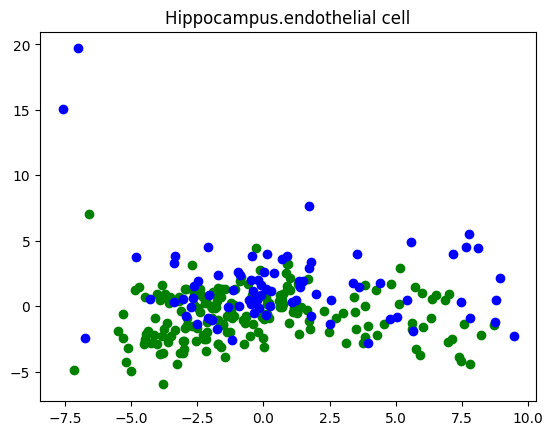

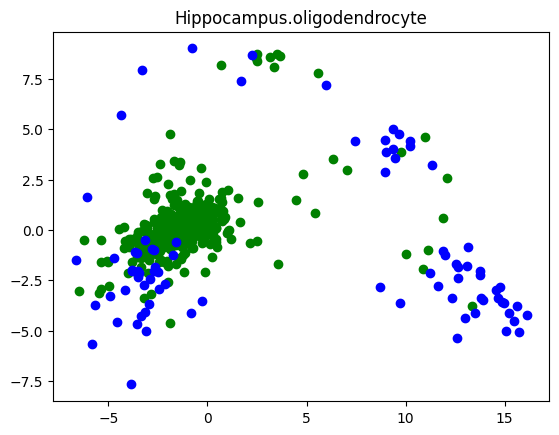

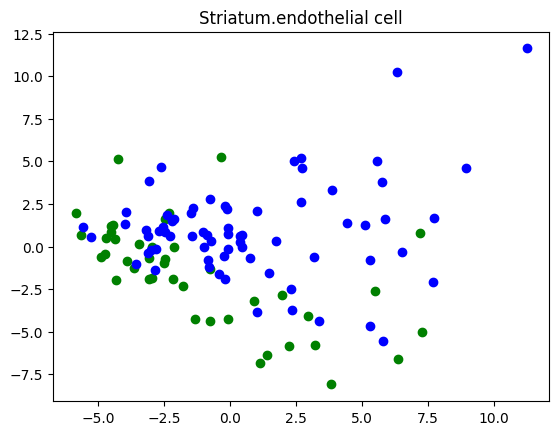

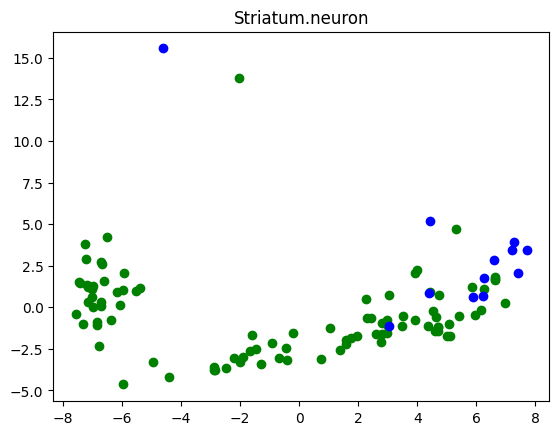

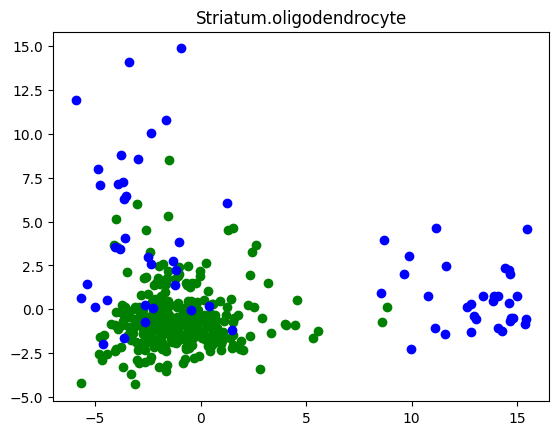

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

for data, gender_labels, file_names in zip(data_list, labels_gender_list, file_names_list):

  pca = PCA(n_components=2)
  transformed_data = pca.fit_transform(data)

  # PCAs colored by gender.
  plt.scatter(transformed_data[gender_labels==0, 0], transformed_data[gender_labels==0, 1], color='green')
  plt.scatter(transformed_data[gender_labels==1, 0], transformed_data[gender_labels==1, 1], color='blue')
  plt.title(file_names)
  plt.show()

  # # PCAs colored by cell ontology.
  # plt.scatter(transformed_data[cell_labels==0, 0], transformed_data[cell_labels==0, 1], color='red')
  # plt.scatter(transformed_data[cell_labels==1, 0], transformed_data[cell_labels==1, 1], color='black')
  # plt.show()

# Real World Data: Both Gender and Cell Ontology Class

Loading and Pre-processing data

In [ ]:
data_file_list = glob.glob('/content/drive/MyDrive/ML project/comb_data_*.csv')
data_list = []
for file in data_file_list:
  data = pd.read_csv(file, index_col = 0)
  data = np.array(data)

  # normalize.
  normalized_data = data/np.sum(data, axis = 1)[:,np.newaxis]

  # scale.
  scaler = StandardScaler()
  single_cell_data_scaled = scaler.fit_transform(normalized_data)

  data_list.append(single_cell_data_scaled)


meta_file_list = glob.glob('/content/drive/MyDrive/ML project/comb_meta_*.csv')
labels_gender_list = []
labels_cell_list = []
labels_cell_names_list = []
for file in meta_file_list:
  file_name = '.'
  file_names_list.append(file_name.join(file.rstrip('.csv').split('_')[2:]))
  meta_data = pd.read_csv(file, index_col = 0)
  labels_gender = meta_data['mouse.sex'].apply(lambda x: 0 if x == 'M' else 1)
  labels_gender = np.array(labels_gender)
  labels_gender_list.append(labels_gender)

  classes = meta_data['cell_ontology_class']
  # labels_cell_names_list.append(classes)
  labels_cell = meta_data['cell_ontology_class'].apply(lambda x: 0 if x == classes[0] else 1)
  labels_cell = np.array(labels_cell)
  labels_cell_list.append(labels_cell)

Running the model

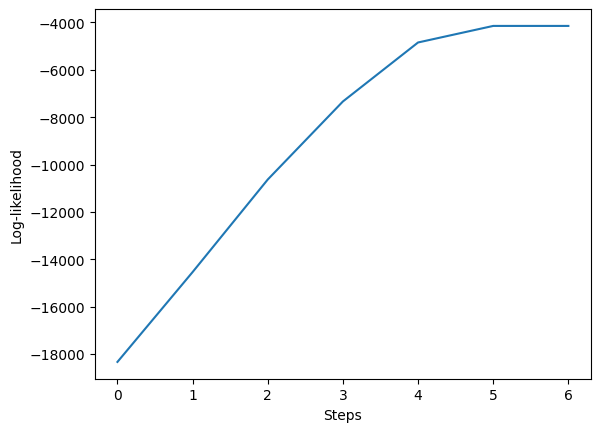

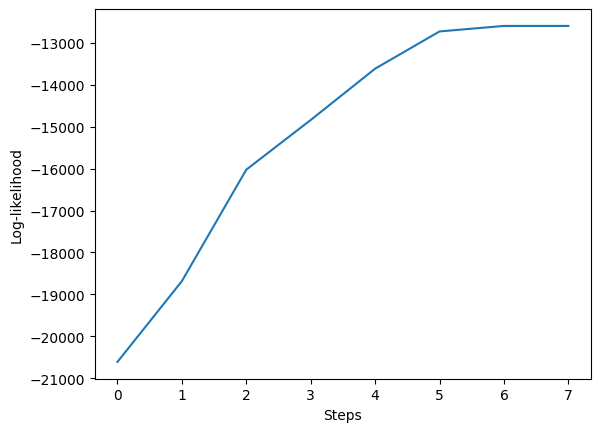

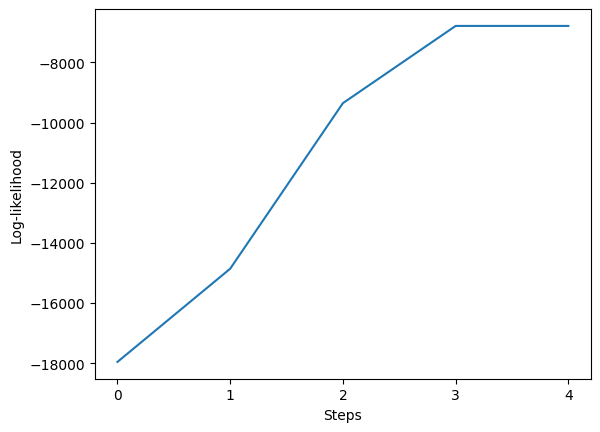

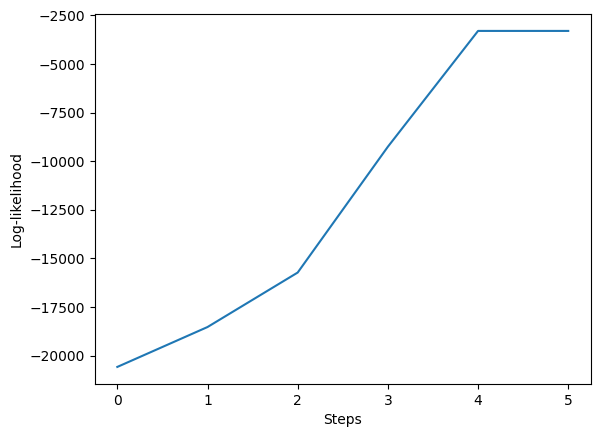

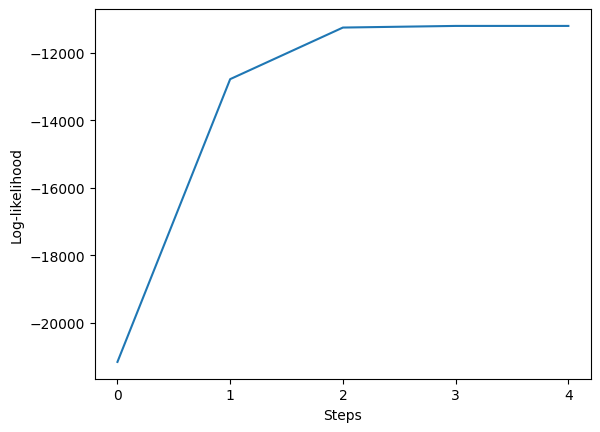

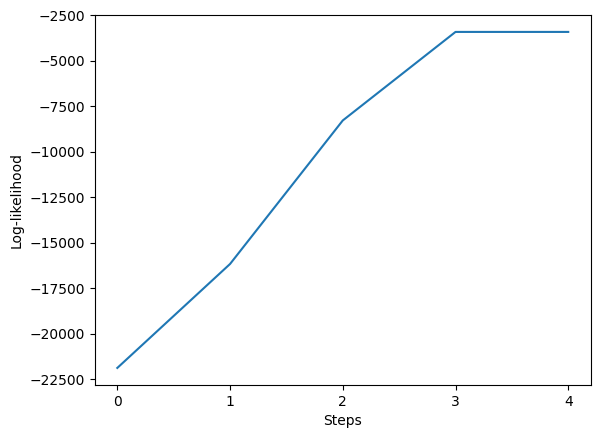

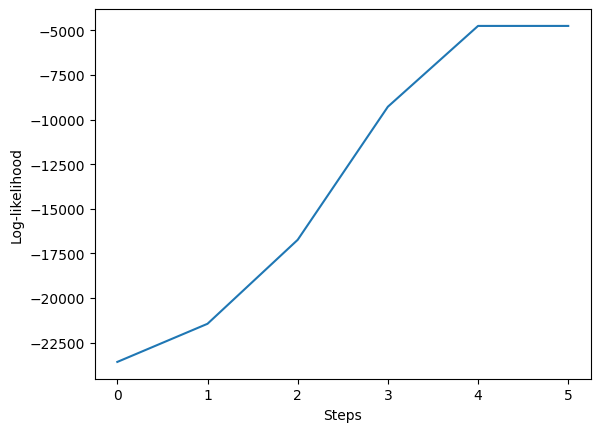

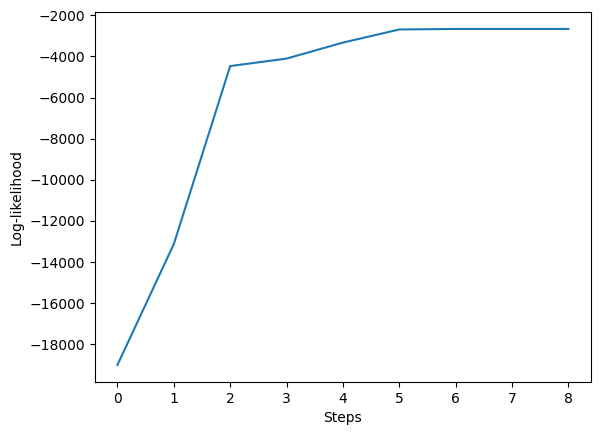

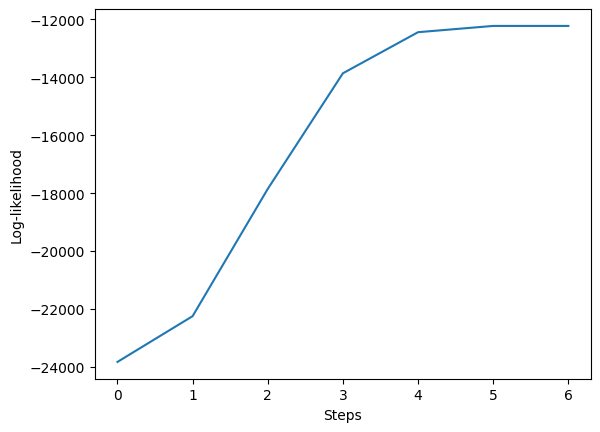

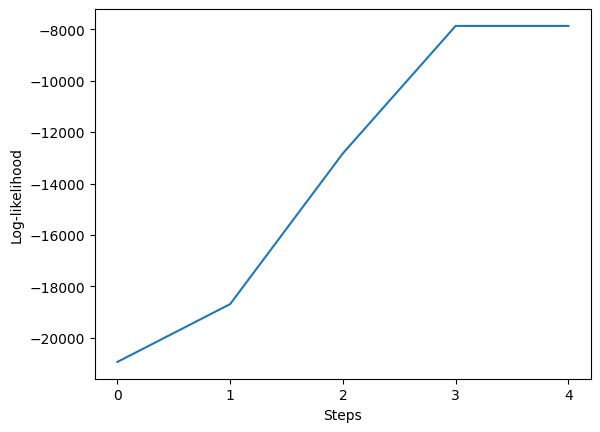

In [ ]:
num_clusters = 2

gender_scores_d = {}
cell_scores_d = {}
preds_list_ontology = []
for data, gender_labels, cell_labels, cell_names in zip(data_list, labels_gender_list, labels_cell_list, file_names_list):

  obj = norm_clusters(data=data, num_steps=10, tol = 1e-2)
  obj.fit(num_clusters=num_clusters)

  # predict.
  preds = np.argmax(obj.responsibilities, axis = 1)
  preds_list_ontology.append(preds)

  # evaluate.
  ## 1. gender.
  gender_scores_d[cell_names] = adjusted_rand_score(gender_labels, preds)
  ## 2. ontology.
  cell_scores_d[cell_names] = adjusted_rand_score(cell_labels, preds)

Adjusted Rand Scores

In [ ]:
gender_scores_d

{'Cerebellum.endothelial cell': 0.028555069782527396,
 'Cerebellum.neuron': -0.02033914576460526,
 'Cerebellum.oligodendrocyte': 0.00720301433014307,
 'Cortex.astrocyte': 0.11889099522718431,
 'Cortex.endothelial cell': 0.0006873195596915842,
 'Cortex.oligodendrocyte': 0.07240371931925775,
 'Hippocampus.endothelial cell': 0.09661356017324031,
 'Hippocampus.oligodendrocyte': 0.2881071891459904,
 'Striatum.endothelial cell': 0.32151610418797266,
 'Striatum.neuron': 0.011364850346436943}

In [ ]:
cell_scores_d

{'Cerebellum.endothelial cell': 0.9602000804038779,
 'Cerebellum.neuron': 0.40692490348425864,
 'Cerebellum.oligodendrocyte': 0.47367759451667246,
 'Cortex.astrocyte': 1.0,
 'Cortex.endothelial cell': 0.7732647285200875,
 'Cortex.oligodendrocyte': 0.7732770949991515,
 'Hippocampus.endothelial cell': 0.7556930746820094,
 'Hippocampus.oligodendrocyte': 0.9212046771339222,
 'Striatum.endothelial cell': 0.7041280743396798,
 'Striatum.neuron': 0.9799995050507551}

Predictions PCA

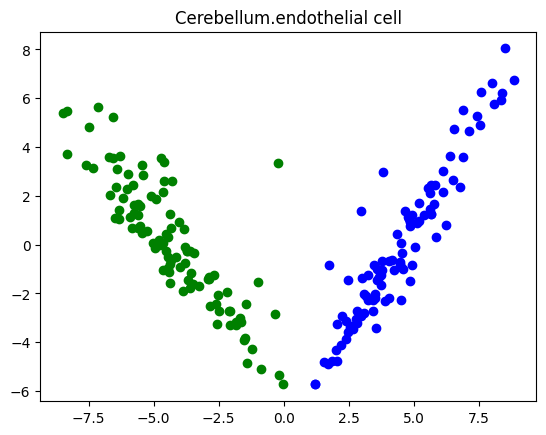

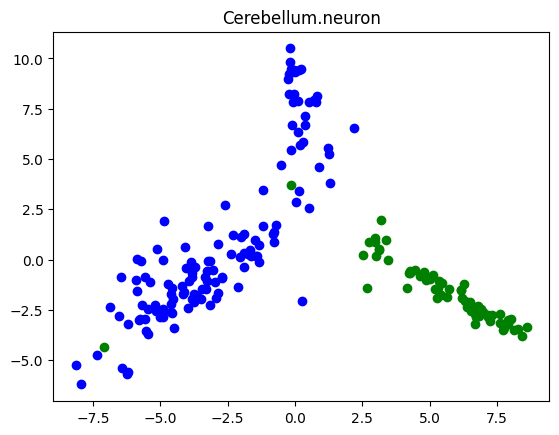

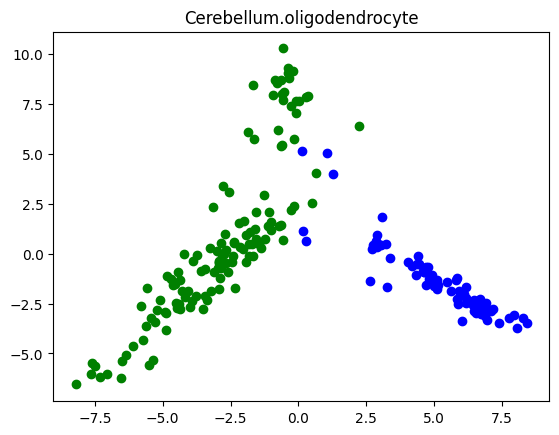

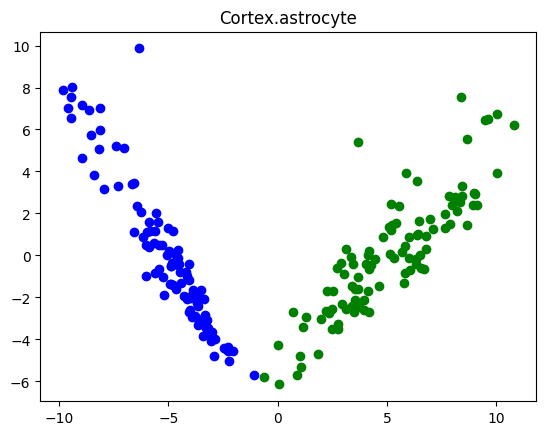

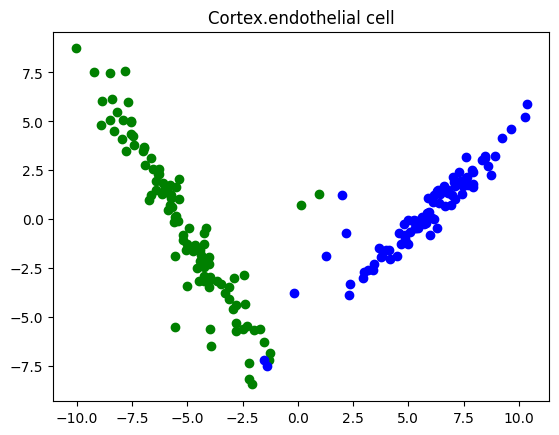

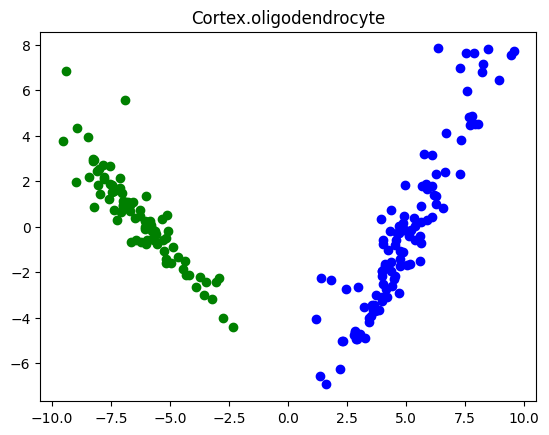

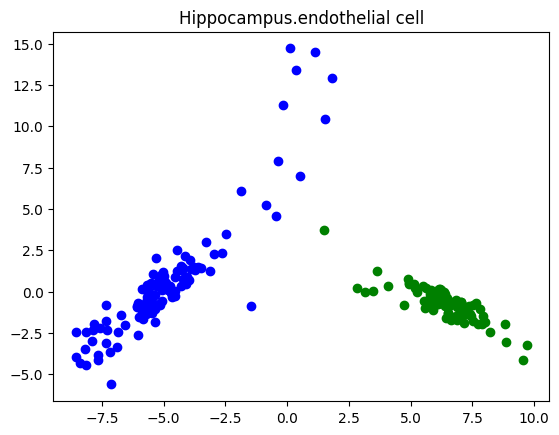

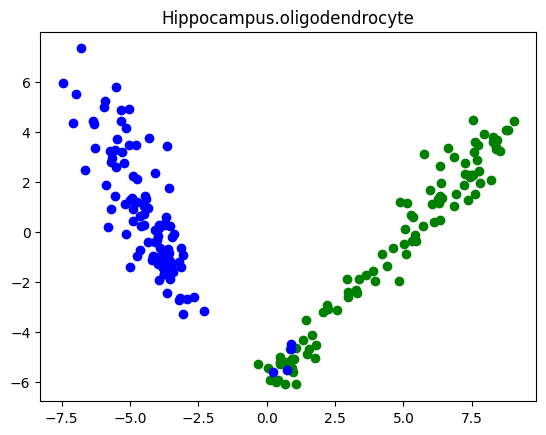

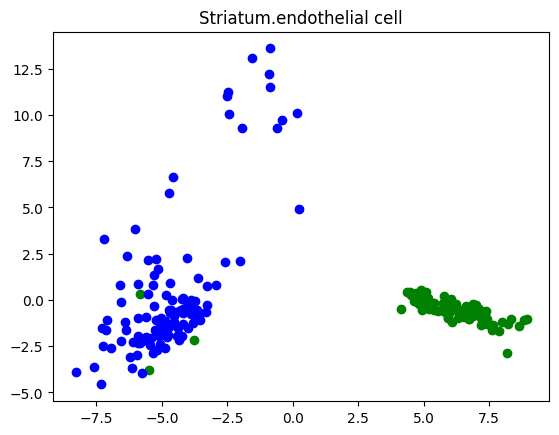

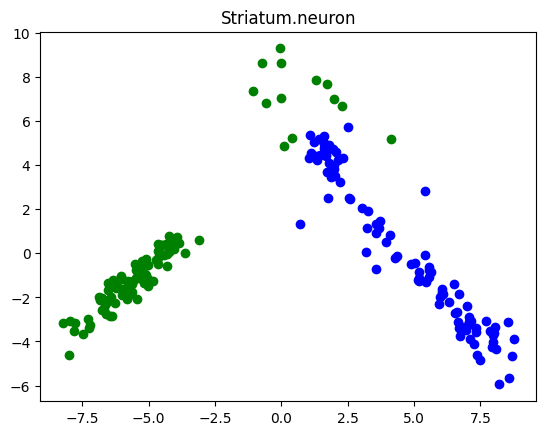

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

for data, gender_labels, file_names, pred in zip(data_list, labels_gender_list, file_names_list, preds_list_ontology):

  pca = PCA(n_components=2)
  transformed_data = pca.fit_transform(data)

  # PCAs colored by gender.
  plt.scatter(transformed_data[pred==0, 0], transformed_data[pred==0, 1], color='green')
  plt.scatter(transformed_data[pred==1, 0], transformed_data[pred==1, 1], color='blue')
  plt.title(file_names)
  plt.show()

  # # PCAs colored by cell ontology.
  # plt.scatter(transformed_data[pred==0, 0], transformed_data[pred==0, 1], color='red')
  # plt.scatter(transformed_data[pred==1, 0], transformed_data[pred==1, 1], color='black')
  # plt.show()

Ground Truth PCA

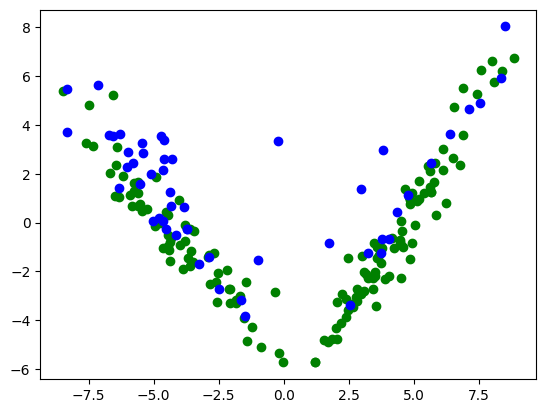

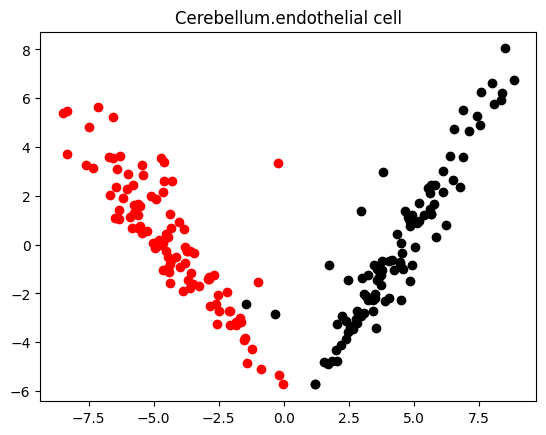

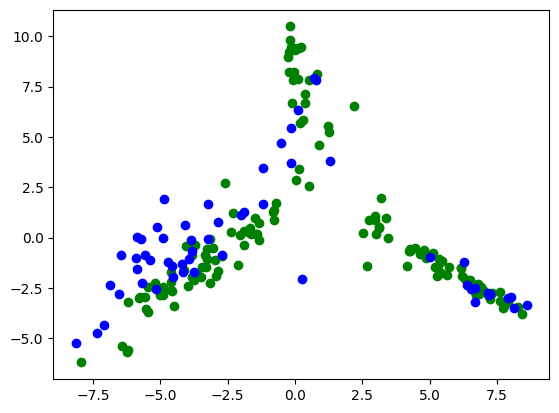

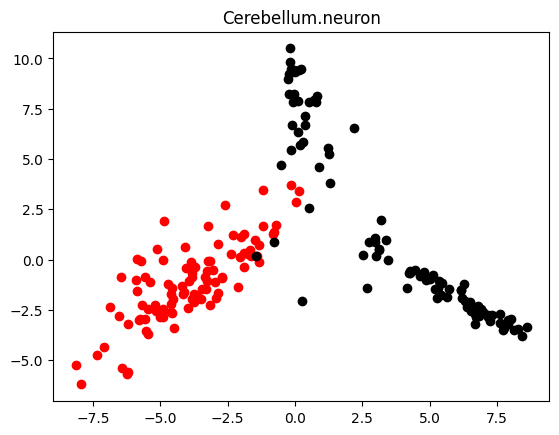

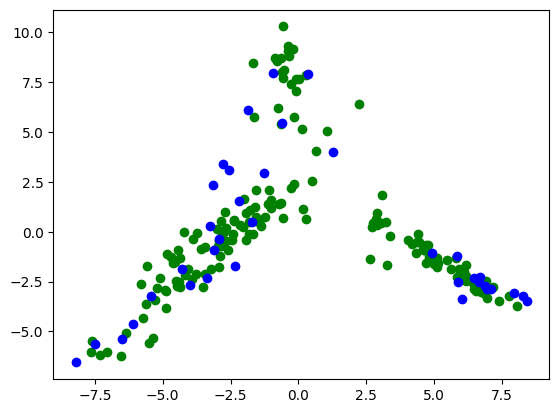

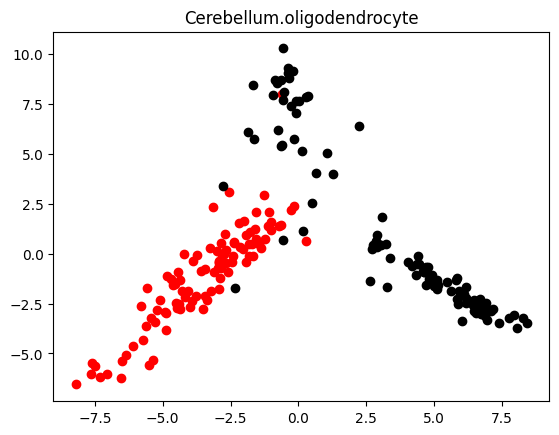

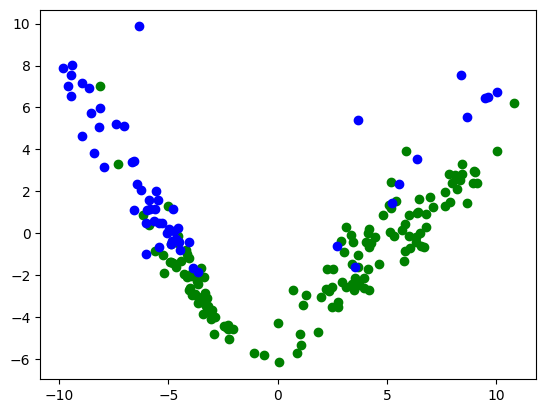

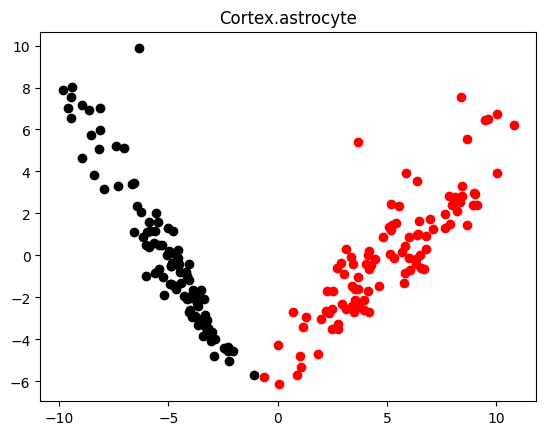

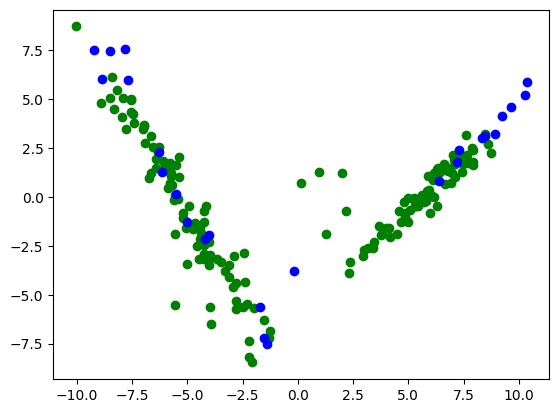

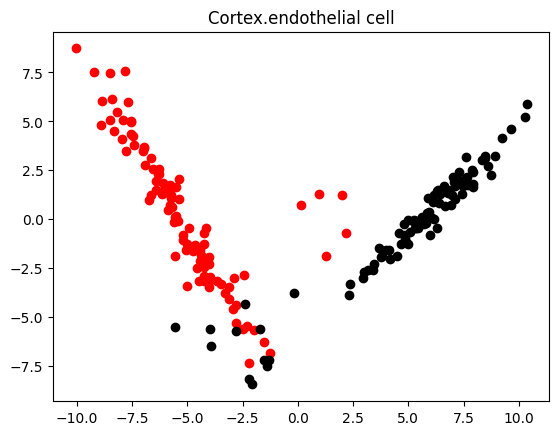

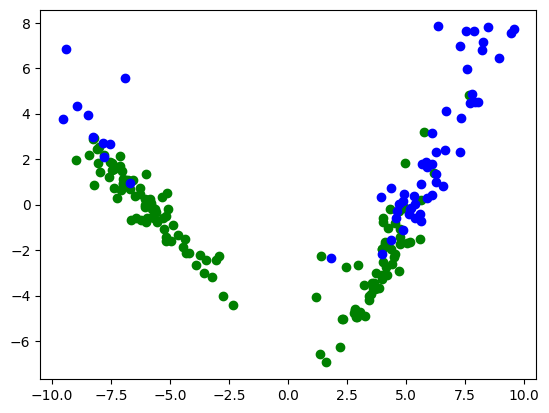

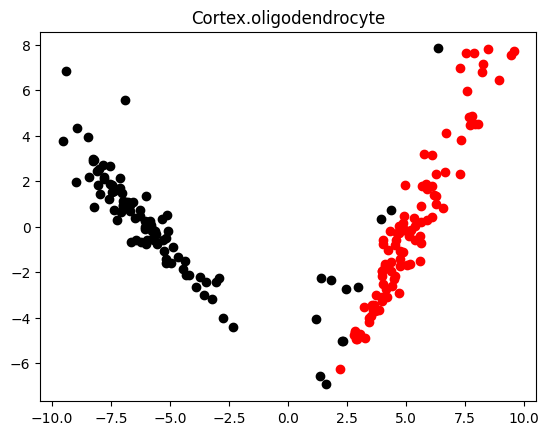

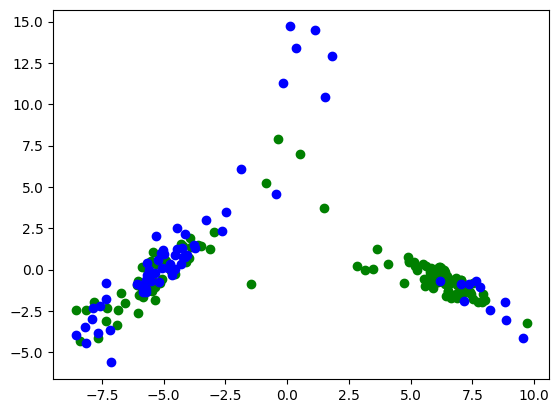

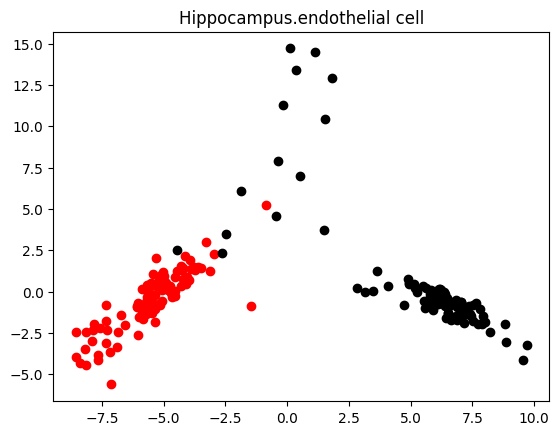

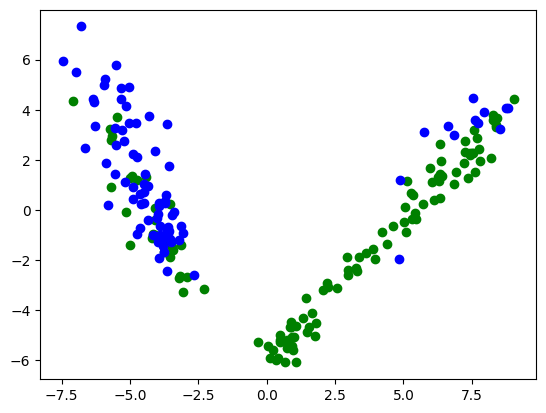

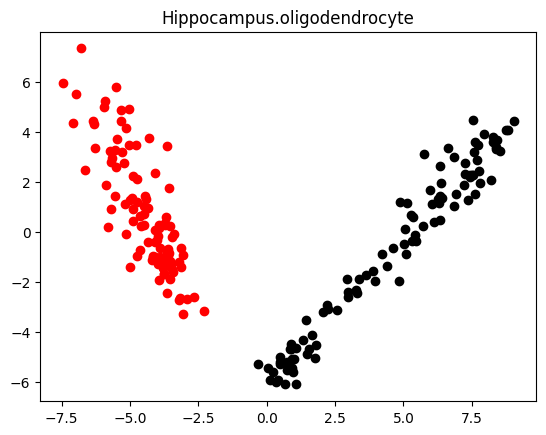

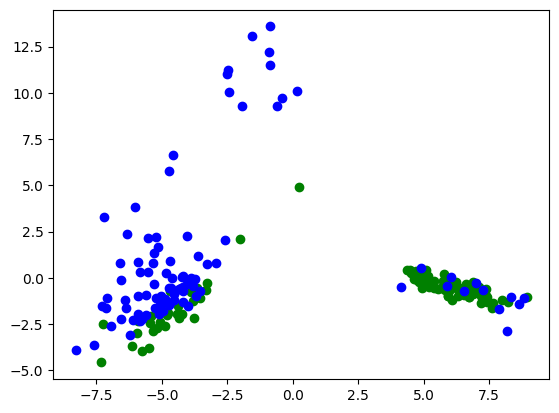

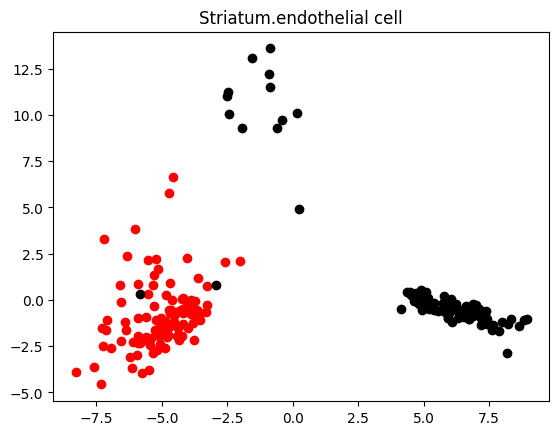

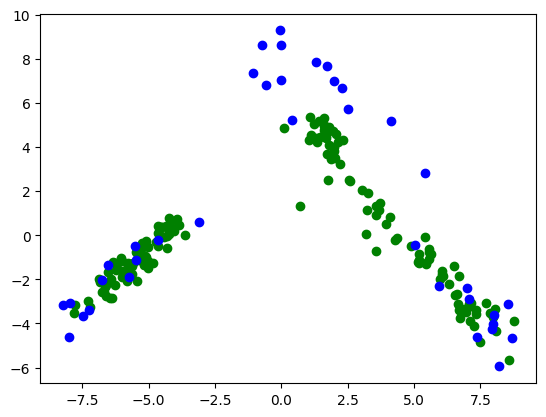

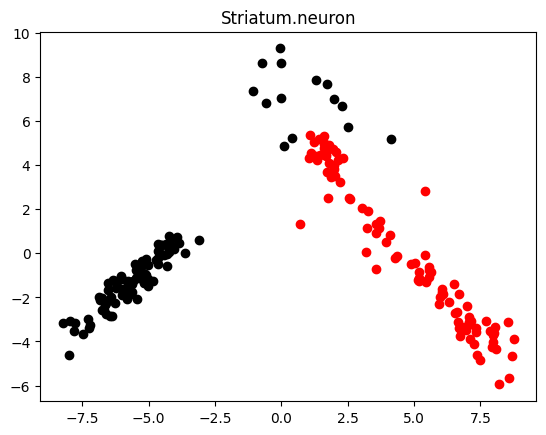

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

for data, gender_labels, cell_labels, cell_names in zip(data_list, labels_gender_list, labels_cell_list, file_names_list):

  pca = PCA(n_components=2)
  transformed_data = pca.fit_transform(data)

  # PCAs colored by gender.
  plt.scatter(transformed_data[gender_labels==0, 0], transformed_data[gender_labels==0, 1], color='green')
  plt.scatter(transformed_data[gender_labels==1, 0], transformed_data[gender_labels==1, 1], color='blue')
  plt.show()

  # PCAs colored by cell ontology.
  plt.scatter(transformed_data[cell_labels==0, 0], transformed_data[cell_labels==0, 1], color='red')
  plt.scatter(transformed_data[cell_labels==1, 0], transformed_data[cell_labels==1, 1], color='black')
  plt.title(cell_names)
  plt.show()